## Load and Inspect Data

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sktime.utils.plotting import plot_series, plot_lags, plot_correlations
from sktime.forecasting.base import ForecastingHorizon
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from statsmodels.tsa.deterministic import DeterministicProcess
import xgboost as xgb
from xgboost import XGBRegressor
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_log_error

import pickle

import warnings
# hide warnings
warnings.filterwarnings("ignore")


In [203]:
# Load datasets
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_stores = pd.read_csv('../data/stores.csv')
df_oil = pd.read_csv('../data/oil.csv')
df_holidays = pd.read_csv('../data/holidays_events.csv')
df_transactions = pd.read_csv('../data/transactions.csv')

# Check first few rows of each dataset
print("Train DataFrame:")
print(df_train.head(), "\n")

print("Test DataFrame:")
print(df_test.head(), "\n")

print("Stores DataFrame:")
print(df_stores.head(), "\n")

print("Oil DataFrame:")
print(df_oil.head(), "\n")

print("Holidays DataFrame:")
print(df_holidays.head(), "\n")

print("Transactions DataFrame:")
print(df_transactions.head(), "\n")

# Check for missing values in each dataset
print("Missing values in Train Data:")
print(df_train.isnull().sum(), "\n")

print("Missing values in Test Data:")
print(df_test.isnull().sum(), "\n")

print("Missing values in Stores Data:")
print(df_stores.isnull().sum(), "\n")

print("Missing values in Oil Data:")
print(df_oil.isnull().sum(), "\n")

print("Missing values in Holidays Data:")
print(df_holidays.isnull().sum(), "\n")

print("Missing values in Transactions Data:")
print(df_transactions.isnull().sum(), "\n")

# Convert date columns to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

# Confirm the conversion of date columns
print("Date columns converted to datetime format.")

Train DataFrame:
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0 

Test DataFrame:
        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0 

Stores DataFrame:
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2  

In [204]:
# Display all columns of a DataFrame
pd.set_option('display.max_columns', None)

## Outlier detection

In [205]:
from sklearn.ensemble import IsolationForest

def detect_outliers_isolation_forest(time_series):
    time_series = time_series.values.reshape(-1, 1)
    iso_forest = IsolationForest(contamination=0.01)
    preds = iso_forest.fit_predict(time_series)
    return preds == -1  # True for outliers


In [226]:
sum_outliers = 0

for store in df_train['store_nbr'].unique():
    for product_family in df_train['family'].unique():
        # Filter the subset for the specific store and product family
        mask = (df_train['store_nbr'] == store) & (df_train['family'] == product_family)
        
        # Get the time series for sales
        ts = df_train.loc[mask, 'sales']
        
        # Detect outliers in this time series
        outliers = detect_outliers_isolation_forest(ts)
        sum_outliers += outliers.sum()
        
        # Calculate the mean of the non-outlier values
        mean_value = ts[~outliers].mean()
        
        # Replace the outliers with the mean in the subset only
        df_train.loc[mask, 'sales'] = np.where(outliers, mean_value, df_train.loc[mask, 'sales'])

print(f'Sum of replaced outliers: {sum_outliers}')


Sum of replaced outliers: 26488


## Create Date-Based Features

In [227]:
# Feature Engineering: Date-based features
def create_date_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_year'] = df['date'].dt.dayofyear
    return df

# Apply the function to both train and test datasets
df_train = create_date_features(df_train)
df_test = create_date_features(df_test)

# Confirm the newly created features
print("Train DataFrame with Date-Based Features:")
print(df_train.head())

print("Test DataFrame with Date-Based Features:")
print(df_test.head())

Train DataFrame with Date-Based Features:
   id       date  store_nbr      family        sales  onpromotion  year   
0   0 2013-01-01          1  AUTOMOTIVE     0.000000            0  2013  \
1   1 2013-01-01          1   BABY CARE     0.000000            0  2013   
2   2 2013-01-01          1      BEAUTY     0.000000            0  2013   
3   3 2013-01-01          1   BEVERAGES  1581.219556            0  2013   
4   4 2013-01-01          1       BOOKS     0.000000            0  2013   

   month  day  day_of_week  week_of_year  day_of_year  
0      1    1            1             1            1  
1      1    1            1             1            1  
2      1    1            1             1            1  
3      1    1            1             1            1  
4      1    1            1             1            1  
Test DataFrame with Date-Based Features:
        id       date  store_nbr      family  onpromotion  year  month  day   
0  3000888 2017-08-16          1  AUTOMOTIVE       

##  Create Lag and Rolling Features

In [228]:
# Feature Engineering: Lag and rolling features for sales
def create_lag_features(df, lags=[1, 7, 14]):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)
    return df

def create_rolling_features(df, windows=[7, 14]):
    for window in windows:
        df[f'sales_roll_mean_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window).mean())
        df[f'sales_roll_std_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window).std())

        df[f'sales_roll_mean_{window}'] = df[f'sales_roll_mean_{window}'].shift(1)
        df[f'sales_roll_std_{window}'] = df[f'sales_roll_std_{window}'].shift(1) 

    return df

# Apply the lag features to the train dataset
df_train = create_lag_features(df_train)
df_train = create_rolling_features(df_train)

# Since the test set lacks sales history, we can't create lag features for it directly
# Fill missing lag feature NaNs with 0
df_train.fillna(0, inplace=True)

# Confirm the newly created lag and rolling features
print("Train DataFrame with Lag and Rolling Features:")
print(df_train.head())

Train DataFrame with Lag and Rolling Features:
   id       date  store_nbr      family        sales  onpromotion  year   
0   0 2013-01-01          1  AUTOMOTIVE     0.000000            0  2013  \
1   1 2013-01-01          1   BABY CARE     0.000000            0  2013   
2   2 2013-01-01          1      BEAUTY     0.000000            0  2013   
3   3 2013-01-01          1   BEVERAGES  1581.219556            0  2013   
4   4 2013-01-01          1       BOOKS     0.000000            0  2013   

   month  day  day_of_week  week_of_year  day_of_year  sales_lag_1   
0      1    1            1             1            1          0.0  \
1      1    1            1             1            1          0.0   
2      1    1            1             1            1          0.0   
3      1    1            1             1            1          0.0   
4      1    1            1             1            1          0.0   

   sales_lag_7  sales_lag_14  sales_roll_mean_7  sales_roll_std_7   
0          0

## Handle missing data

In [229]:
# Handle missing oil prices using forward fill
df_oil['dcoilwtico'].fillna(method='ffill', inplace=True)

# Check if there are any remaining missing values in oil
print("Remaining missing values in oil data:")
print(df_oil.isnull().sum())

# Ensure lag and rolling feature NaNs in train data are filled (we already did this in the previous step)
df_train.fillna(0, inplace=True)

# Confirm no missing values in train data
print("Remaining missing values in train data after filling:")
print(df_train.isnull().sum())

# Since the test set doesn't have historical sales, we won't create lag/rolling features for it. 
# However, ensure there are no other missing values in the test dataset.
df_test.fillna(0, inplace=True)
print("Remaining missing values in test data after filling:")
print(df_test.isnull().sum())

# Handle the last remaining missing oil price using backward fill
df_oil['dcoilwtico'].fillna(method='bfill', inplace=True)

# Verify there are no more missing values in the oil data
print("Remaining missing values in oil data after backfill:")
print(df_oil.isnull().sum())

Remaining missing values in oil data:
date          0
dcoilwtico    1
dtype: int64
Remaining missing values in train data after filling:
id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
year                  0
month                 0
day                   0
day_of_week           0
week_of_year          0
day_of_year           0
sales_lag_1           0
sales_lag_7           0
sales_lag_14          0
sales_roll_mean_7     0
sales_roll_std_7      0
sales_roll_mean_14    0
sales_roll_std_14     0
dtype: int64
Remaining missing values in test data after filling:
id              0
date            0
store_nbr       0
family          0
onpromotion     0
year            0
month           0
day             0
day_of_week     0
week_of_year    0
day_of_year     0
dtype: int64
Remaining missing values in oil data after backfill:
date          0
dcoilwtico    0
dtype: int64


In [230]:
# Now merge the 'cluster' information from df_stores
df_train = df_train.merge(df_stores[['store_nbr', 'cluster', 'type', 'city', 'state']], on='store_nbr', how='left')
df_test = df_test.merge(df_stores[['store_nbr', 'cluster', 'type', 'city', 'state']], on='store_nbr', how='left')

#rename type of store
df_train = df_train.rename(columns= {'type': 'type_store' })
df_test = df_test.rename(columns= {'type': 'type_store' })

# Check if the cluster is merged correctly
print("Cluster column in train data:")
print(df_train[['store_nbr', 'cluster']].head())

print("Cluster column in test data:")
print(df_test[['store_nbr', 'cluster']].head())


Cluster column in train data:
   store_nbr  cluster
0          1       13
1          1       13
2          1       13
3          1       13
4          1       13
Cluster column in test data:
   store_nbr  cluster
0          1       13
1          1       13
2          1       13
3          1       13
4          1       13


## Add Holiday Feature

In [231]:
# Handle holiday data: create a flag for holidays and calculate days to next holiday
def add_holiday_features(df, df_holidays):
    # # Filter national holidays only
    # holidays_df = holidays_df[holidays_df['locale'] == 'National'].copy()
    
    # # Merge holidays with the data based on the date
    # df = df.merge(holidays_df[['date', 'type']], on='date', how='left')
    
    # # Flag if the date is a holiday
    # df['is_holiday'] = df['type'].notnull().astype(int)
    
    # # Drop the 'type' column after creating the flag
    # df.drop(columns=['type'], inplace=True)

    # Step 1: Split df_holidays based on the locale type
    national_holidays = df_holidays[df_holidays['locale'] == 'National']
    regional_holidays = df_holidays[df_holidays['locale'] == 'Regional']
    local_holidays = df_holidays[df_holidays['locale'] == 'Local']

    # Step 2: Merge each type separately

    # 2.1 National Holidays: Merge only on date
    df_merged_national = pd.merge(df, national_holidays, on='date', how='left')

    # 2.2 Regional Holidays: Merge on date and state (locale_name corresponds to state in df_merged)
    df_merged_regional = pd.merge(
        df, 
        regional_holidays, 
        left_on=['date', 'state'], 
        right_on=['date', 'locale_name'], 
        how='left'
    )

    # 2.3 Local Holidays: Merge on date and city (locale_name corresponds to city in df_merged)
    df_merged_local = pd.merge(
        df, 
        local_holidays, 
        left_on=['date', 'city'], 
        right_on=['date', 'locale_name'], 
        how='left'
    )

    # Step 3: Combine the results

    # Start with National holidays
    df_combined = df_merged_national.copy()

    # Add columns from Regional merge, without duplicating
    df_combined = df_combined.combine_first(df_merged_regional)

    # Add columns from Local merge, without duplicating
    df_combined = df_combined.combine_first(df_merged_local)

    # Clean-up step (optional): You can drop unnecessary columns or fill NaN values
    # Drop locale_name columns if you want
    df_combined = df_combined.drop(['locale_name'], axis=1, errors='ignore')

    # Fill NaN values in the description or type columns as needed
    df_combined['description'] = df_combined['description'].fillna('No Holiday')

    #Create is_holiday column
    df_combined['is_holiday'] = df_combined['type'].notna().astype(int)

    # Show the combined dataframe
    df_merged = df_combined.copy()

    return df_merged

# Apply holiday features to train and test datasets
df_train = add_holiday_features(df_train, df_holidays)
df_test = add_holiday_features(df_test, df_holidays)

# Confirm that the holiday feature was added
print("Train DataFrame with Holiday Features:")
print(df_train[['date', 'is_holiday']].head())

print("Test DataFrame with Holiday Features:")
print(df_test[['date', 'is_holiday']].head())

Train DataFrame with Holiday Features:
        date  is_holiday
0 2013-01-01           1
1 2013-01-01           1
2 2013-01-01           1
3 2013-01-01           1
4 2013-01-01           1
Test DataFrame with Holiday Features:
        date  is_holiday
0 2017-08-16           0
1 2017-08-16           0
2 2017-08-16           0
3 2017-08-16           0
4 2017-08-16           0


In [232]:
# Add interaction between promotion and holiday, and promotion and store cluster
df_train['promo_holiday'] = df_train['onpromotion'] * df_train['is_holiday']
df_train['store_cluster_promo'] = df_train['onpromotion'] * df_train['cluster']

df_test['promo_holiday'] = df_test['onpromotion'] * df_test['is_holiday']
df_test['store_cluster_promo'] = df_test['onpromotion'] * df_test['cluster']

# Check if the new features are added
print("New interaction features in train data:")
print(df_train[['promo_holiday', 'store_cluster_promo']].head())

print("New interaction features in test data:")
print(df_test[['promo_holiday', 'store_cluster_promo']].head())

New interaction features in train data:
   promo_holiday  store_cluster_promo
0              0                    0
1              0                    0
2              0                    0
3              0                    0
4              0                    0
New interaction features in test data:
   promo_holiday  store_cluster_promo
0              0                    0
1              0                    0
2              0                   26
3              0                  260
4              0                    0


## Add Promotion Features

In [233]:
# Create time since the last promotion for each store and family
def create_time_since_last_promotion(df):
    df['promo_not_active'] = (df['onpromotion'] == 0).astype(int)
    
    # Calculate the cumulative sum of days since the last promotion within each store and product family
    df['time_since_last_promo'] = df.groupby(['store_nbr', 'family'])['promo_not_active'].cumsum()
    
    # Drop the helper column 'promo_not_active'
    df.drop(columns=['promo_not_active'], inplace=True)
    
    return df

# Apply to train dataset (test set doesn't have sales history, so we skip promotions there)
df_train = create_time_since_last_promotion(df_train)

# Confirm the new promotion-related feature in the train dataset
print("Train DataFrame with Promotion Features:")
print(df_train[['date', 'store_nbr', 'family', 'onpromotion', 'time_since_last_promo']].head())

Train DataFrame with Promotion Features:
        date  store_nbr      family  onpromotion  time_since_last_promo
0 2013-01-01          1  AUTOMOTIVE            0                      1
1 2013-01-01          1   BABY CARE            0                      1
2 2013-01-01          1      BEAUTY            0                      1
3 2013-01-01          1   BEVERAGES            0                      1
4 2013-01-01          1       BOOKS            0                      1


## Model Training

In [234]:
# Merge oil data into the train dataset based on date
df_train = df_train.merge(df_oil[['date', 'dcoilwtico']], on='date', how='left')

# Merge transactions data into the train dataset based on date and store number
df_train = df_train.merge(df_transactions[['date', 'store_nbr', 'transactions']], on=['date', 'store_nbr'], how='left')

# Fill any remaining NaN values in dcoilwtico and transactions
df_train['dcoilwtico'].fillna(0, inplace=True)
df_train['transactions'].fillna(0, inplace=True)

# Verify that the columns are present after merging
print(df_train[['date', 'store_nbr', 'dcoilwtico', 'transactions']].head())

        date  store_nbr  dcoilwtico  transactions
0 2013-01-01          1       93.14           0.0
1 2013-01-01          1       93.14           0.0
2 2013-01-01          1       93.14           0.0
3 2013-01-01          1       93.14           0.0
4 2013-01-01          1       93.14           0.0


## Enhancing feature engineering

In [235]:
# 1.1 Create additional lag features for 30, 60, and 90 days
def create_additional_lag_features(df, lags=[30, 60, 90]):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)
    return df

# 1.2 Create cyclic features for day_of_week and day_of_year
def create_cyclic_features(df):
    # Cyclic transformation of day_of_week
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Cyclic transformation of day_of_year
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    return df

# Apply the additional lag features to the train dataset
df_train = create_additional_lag_features(df_train)

# Apply the cyclic transformations to the train dataset
df_train = create_cyclic_features(df_train)

# Fill missing values resulting from lag feature creation
df_train.fillna(0, inplace=True)

# Verify that the new features are created
print("Train DataFrame with additional lag and cyclic features:")
print(df_train[['sales_lag_30', 'sales_lag_60', 'sales_lag_90', 'day_of_week_sin', 'day_of_week_cos', 'day_of_year_sin', 'day_of_year_cos']].head())

Train DataFrame with additional lag and cyclic features:
   sales_lag_30  sales_lag_60  sales_lag_90  day_of_week_sin  day_of_week_cos   
0           0.0           0.0           0.0         0.781831          0.62349  \
1           0.0           0.0           0.0         0.781831          0.62349   
2           0.0           0.0           0.0         0.781831          0.62349   
3           0.0           0.0           0.0         0.781831          0.62349   
4           0.0           0.0           0.0         0.781831          0.62349   

   day_of_year_sin  day_of_year_cos  
0         0.017213         0.999852  
1         0.017213         0.999852  
2         0.017213         0.999852  
3         0.017213         0.999852  
4         0.017213         0.999852  


## Create more Features

In [236]:
def create_lag_features(df, lags=[1, 7, 14, 30, 60, 90, 180]):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)
    return df

# Apply lag features to the train dataset only
df_train = create_lag_features(df_train)

# In the test dataset, we won't have 'sales' data for lag features,
# so fill missing lag values with 0 or any default value you want.
df_test.fillna(0, inplace=True)

# Check if the lag features are correctly applied in df_train
print("Train data with lag features:")
print(df_train[['store_nbr', 'family', 'sales', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14']].head())

# If you still want to include lag features in the test set,
# you can use forward-fill based on the last available training data
# or initialize them with 0 for predictions (depending on your approach).

Train data with lag features:
   store_nbr      family        sales  sales_lag_1  sales_lag_7  sales_lag_14
0          1  AUTOMOTIVE     0.000000          NaN          NaN           NaN
1          1   BABY CARE     0.000000          NaN          NaN           NaN
2          1      BEAUTY     0.000000          NaN          NaN           NaN
3          1   BEVERAGES  1581.219556          NaN          NaN           NaN
4          1       BOOKS     0.000000          NaN          NaN           NaN


In [237]:
# Define a function to calculate days to next holiday and days since last holiday
def add_holiday_distance_features(df, holidays_df):
    holidays_df['date'] = pd.to_datetime(holidays_df['date'])
    holidays_df = holidays_df[holidays_df['transferred'] == False]

    # Create a list of unique holiday dates
    holiday_dates = holidays_df['date'].unique()

    df['days_until_next_holiday'] = df['date'].apply(lambda x: min((holiday_dates - x).days) if x < max(holiday_dates) else 0)
    df['days_since_last_holiday'] = df['date'].apply(lambda x: min((x - holiday_dates).days) if x > min(holiday_dates) else 0)
    
    return df

# Apply the holiday distance features to the train and test datasets
df_train = add_holiday_distance_features(df_train, df_holidays)
df_test = add_holiday_distance_features(df_test, df_holidays)

In [238]:
# Create cyclic features for day of year and day of week
df_train['day_of_year_sin'] = np.sin(2 * np.pi * df_train['day_of_year'] / 365)
df_train['day_of_year_cos'] = np.cos(2 * np.pi * df_train['day_of_year'] / 365)
df_train['day_of_week_sin'] = np.sin(2 * np.pi * df_train['day_of_week'] / 7)
df_train['day_of_week_cos'] = np.cos(2 * np.pi * df_train['day_of_week'] / 7)

df_test['day_of_year_sin'] = np.sin(2 * np.pi * df_test['day_of_year'] / 365)
df_test['day_of_year_cos'] = np.cos(2 * np.pi * df_test['day_of_year'] / 365)
df_test['day_of_week_sin'] = np.sin(2 * np.pi * df_test['day_of_week'] / 7)
df_test['day_of_week_cos'] = np.cos(2 * np.pi * df_test['day_of_week'] / 7)

In [239]:
# Create rolling mean and standard deviation features for different window sizes
def create_rolling_features(df, windows=[7, 14, 30, 60, 90, 180]):
    for window in windows:
        df[f'sales_roll_mean_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window).mean())
        df[f'sales_roll_std_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window).std())

        df[f'sales_roll_mean_{window}'] = df[f'sales_roll_mean_{window}'].shift(1)
        df[f'sales_roll_std_{window}'] = df[f'sales_roll_std_{window}'].shift(1) 
    return df

# Apply rolling features to the training data
df_train = create_rolling_features(df_train)

# Since there are no sales data in the test set, fill missing rolling feature values with 0
df_test.fillna(0, inplace=True)

## Feature Engineering: Seasonality and Interaction Features

In [240]:
# Cyclic features for day of week and day of year
def add_cyclic_features(df):
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    return df

# Apply to both train and test datasets
df_train = add_cyclic_features(df_train)
df_test = add_cyclic_features(df_test)

# Add interaction between promotion and holiday, and promotion and store cluster
df_train['promo_holiday'] = df_train['onpromotion'] * df_train['is_holiday']
df_train['store_cluster_promo'] = df_train['onpromotion'] * df_train['cluster']

df_test['promo_holiday'] = df_test['onpromotion'] * df_test['is_holiday']
df_test['store_cluster_promo'] = df_test['onpromotion'] * df_test['cluster']

# Updated feature list to include cyclic and interaction features
features = ['onpromotion', 'dcoilwtico', 'transactions', 'year', 'month', 'day', 
            'day_of_week_sin', 'day_of_week_cos', 'day_of_year_sin', 'day_of_year_cos',
            'week_of_year', 'time_since_last_promo', 'is_holiday', 
            'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 
            'sales_lag_60', 'sales_lag_90',
            'sales_roll_mean_7', 'sales_roll_mean_14', 
            'sales_roll_std_7', 'sales_roll_std_14'
            'promo_holiday', 'store_cluster_promo',
            'store_nbr', 'family',
            'type_store', 'cluster']

# Prepare the feature matrix and target variable
df_train = df_train.dropna()
df_test = df_test.dropna()

In [ ]:
features = ['onpromotion', 'transactions', 'year', 'month', 'day', 
            'day_of_week_sin', 'day_of_week_cos', 'day_of_year_sin', 'day_of_year_cos',
            'week_of_year', 'time_since_last_promo', 'is_holiday', 
            'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 
            'sales_lag_60', 'sales_lag_90',
            'promo_holiday', 'store_cluster_promo'
            ]

In [187]:
features_2 = ['onpromotion', 'dcoilwtico', 'transactions', 'year', 'month', 'day', 
            'day_of_week_sin', 'day_of_week_cos', 'day_of_year_sin', 'day_of_year_cos',
            'week_of_year', 'time_since_last_promo', 'is_holiday', 
            'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 
            'sales_lag_60', 'sales_lag_90',
            'promo_holiday', 'store_cluster_promo'
            ]

In [184]:
features_3 = ['onpromotion', 'dcoilwtico', 'transactions', 'year', 'month', 'day', 
            'day_of_week_sin', 'day_of_week_cos', 'day_of_year_sin', 'day_of_year_cos',
            'week_of_year', 'time_since_last_promo', 'is_holiday', 
            'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 'sales_lag_60', 'sales_lag_90',
            'sales_roll_mean_7', 'sales_roll_mean_14', 'sales_roll_mean_30', 'sales_roll_mean_60', 'sales_roll_mean_90', 'sales_roll_mean_180',
            'sales_roll_std_7', 'sales_roll_std_14', 'sales_roll_std_30','sales_roll_std_60', 'sales_roll_std_90', 'sales_roll_std_180',
            'promo_holiday', 'store_cluster_promo',
            'store_nbr', 'family']

## Encoding

In [242]:
def encoding(df, cat_columns):

    df = pd.get_dummies(df, columns=cat_columns)

    return df

In [243]:
#Categorocal columns
cat_columns = ['family', 'store_nbr']

# Convert columns to categorical
df_train[cat_columns] = df_train[cat_columns].apply(lambda col: col.astype('category'))
df_test[cat_columns] = df_test[cat_columns].apply(lambda col: col.astype('category'))

In [167]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2687256 entries, 320760 to 3008015
Data columns (total 51 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   date                     datetime64[ns]
 2   store_nbr                category      
 3   family                   category      
 4   sales                    float64       
 5   onpromotion              int64         
 6   year                     int32         
 7   month                    int32         
 8   day                      int32         
 9   day_of_week              int32         
 10  week_of_year             UInt32        
 11  day_of_year              int32         
 12  sales_lag_1              float64       
 13  sales_lag_7              float64       
 14  sales_lag_14             float64       
 15  sales_roll_mean_7        float64       
 16  sales_roll_std_7         float64       
 17  sales_roll_mean_14       fl

In [244]:
#Create training variables with one-hot encoding
#X = encoding(df_train[features], cat_columns)  #uncomment for one hot encoding
X = df_train[features]  #comment if one hot encoding is on
y = df_train['sales']

## Regularization Tuning: Fine-tune L1 and L2 Regularization

In [118]:
# Set XGBoost parameters with fine-tuned regularization
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,  # Equivalent to 'num_leaves' in LightGBM
    'min_child_weight': 50,  # Equivalent to 'min_data_in_leaf'
    'alpha': 0.1,  # L1 regularization, equivalent to 'lambda_l1' in LightGBM
    'lambda': 1,   # L2 regularization, equivalent to 'lambda_l2' in LightGBM
    'subsample': 0.8,  # Equivalent to 'bagging_fraction'
    'colsample_bytree': 0.9,  # Equivalent to 'feature_fraction'
    'random_state': 42
}

# Train the model using TimeSeriesSplit and XGBoost
tscv = TimeSeriesSplit(n_splits=5)
rmsle_list = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Create DMatrix for XGBoost
    train_data = xgb.DMatrix(X_train, label=y_train)
    val_data = xgb.DMatrix(X_val, label=y_val)

    # Train the model with early stopping
    model = xgb.train(params, train_data, num_boost_round=1000, evals=[(val_data, 'eval')],
                      early_stopping_rounds=50, verbose_eval=100)

    # Predictions and RMSLE Calculation
    y_val_pred = model.predict(val_data)
    y_val_pred = np.clip(y_val_pred, a_min=0, a_max=None)  # Clip negative predictions

    rmsle = np.sqrt(mean_squared_log_error(y_val, y_val_pred))
    rmsle_list.append(rmsle)
    print(f"Validation RMSLE: {rmsle}")

# Average RMSLE across all splits
avg_rmsle = np.mean(rmsle_list)
print(f"Average RMSLE across all splits: {avg_rmsle}")


[0]	eval-rmse:949.97295
[100]	eval-rmse:407.56700
[200]	eval-rmse:246.16049
[300]	eval-rmse:211.52265
[400]	eval-rmse:204.85692
[500]	eval-rmse:203.17677
[597]	eval-rmse:203.52631
Validation RMSLE: 1.1216509094555154
[0]	eval-rmse:1023.59433
[100]	eval-rmse:442.66033
[200]	eval-rmse:274.85911
[300]	eval-rmse:241.84813
[400]	eval-rmse:236.66090
[500]	eval-rmse:236.12999
[600]	eval-rmse:235.63033
[700]	eval-rmse:235.20983
[800]	eval-rmse:234.99351
[836]	eval-rmse:235.00852
Validation RMSLE: 0.8653179473982519
[0]	eval-rmse:1232.52192
[100]	eval-rmse:548.97674
[200]	eval-rmse:338.41501
[300]	eval-rmse:285.12475
[400]	eval-rmse:272.37242
[500]	eval-rmse:268.07355
[600]	eval-rmse:265.66767
[700]	eval-rmse:264.77787
[800]	eval-rmse:264.16141
[900]	eval-rmse:263.91038
[999]	eval-rmse:263.66600
Validation RMSLE: 0.6436502646162371
[0]	eval-rmse:1292.49115
[100]	eval-rmse:624.67806
[200]	eval-rmse:442.19372
[300]	eval-rmse:402.04390
[400]	eval-rmse:392.30190
[500]	eval-rmse:388.89527
[600]	eval

In [245]:
#train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle= False, test_size= 39*54*33)

# Create DMatrix for XGBoost
train_data = xgb.DMatrix(X_train, label=y_train)
val_data = xgb.DMatrix(X_val, label=y_val)

# Set XGBoost parameters with fine-tuned regularization
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,  # Equivalent to 'num_leaves' in LightGBM
    'min_child_weight': 50,  # Equivalent to 'min_data_in_leaf'
    'alpha': 0.1,  # L1 regularization, equivalent to 'lambda_l1' in LightGBM
    'lambda': 1,   # L2 regularization, equivalent to 'lambda_l2' in LightGBM
    'subsample': 0.8,  # Equivalent to 'bagging_fraction'
    'colsample_bytree': 0.9,  # Equivalent to 'feature_fraction'
    'random_state': 42
}

# Train the model with early stopping
model_2 = xgb.train(params, train_data, num_boost_round=1000, evals=[(val_data, 'eval')],
                      early_stopping_rounds=50, verbose_eval=100)

# Predictions and RMSLE Calculation
y_train_pred = model_2.predict(train_data)
y_train_pred = np.clip(y_train_pred, a_min=0, a_max=None)  # Clip negative predictions

y_val_pred = model_2.predict(val_data)
y_val_pred = np.clip(y_val_pred, a_min=0, a_max=None)  # Clip negative predictions

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_val_pred))
print(f"Training RMSLE: {rmsle_train}")
print(f"Validation RMSLE: {rmsle_val}")

[0]	eval-rmse:1251.94873
[100]	eval-rmse:490.83575
[200]	eval-rmse:254.87169
[300]	eval-rmse:207.11145
[400]	eval-rmse:199.73708
[500]	eval-rmse:197.62222
[600]	eval-rmse:196.49270
[700]	eval-rmse:195.83750
[800]	eval-rmse:195.18071
[900]	eval-rmse:194.60586
[999]	eval-rmse:194.18139
Training RMSLE: 0.6855568903388525
Validation RMSLE: 0.5048869718042637


In [120]:
def combine_results(y_train, df_train):
    y_train_all = y_train.to_frame().rename(columns= {'sales': 'true'})
    y_train_all['pred'] = y_train_pred

    y_val_all = y_val.to_frame().rename(columns= {'sales': 'true'})
    y_val_all['pred'] = y_val_pred

    y_all = pd.concat([y_train_all, y_val_all], axis= 0)
    index = df_train.index
    date = df_train.date
    y_all['id']= index
    y_all['date']= date
    y_all = y_all.reset_index()
    y_all = y_all.set_index('id')

    stores = df_train['store_nbr'].to_frame()
    family = df_train['family'].to_frame()

    y_all['store_nbr'] = stores['store_nbr']
    y_all['family'] = family['family']
    y_all = y_all.drop(columns= 'index')

    y_all = y_all.sort_index()
    y_all = y_all.set_index('date')

    return y_all

In [198]:
y_all = combine_results(y_train, df_train)

In [122]:
def create_ts_dic(data):

    group = data.groupby(['store_nbr', 'family'])

    #create dic
    dic_groups = {}

    #feature engineering of data frames
    for (store, family), df in group:

        #check if store already in dic
        if store not in dic_groups:
            dic_groups[store] = {}

        #store df in nested dic
        dic_groups[store][family] = df
    
    return dic_groups

In [199]:
dic_groups = create_ts_dic(y_all)

In [124]:
#plot results for store and family

def plot_results(dic_groups, store, family, interval = 100, val_size=39):

    """Function to plot MAE values for train and val series and graph 
        with true and predicted values
    """

    df = dic_groups[store][family]
    
    df_train = df[:-val_size]
    df_val = df[-val_size:]

    train_true = df_train['true']
    train_pred = df_train['pred']
    val_true = df_val['true']
    val_pred = df_val['pred']

    # plotting for illustration
    plot_series(train_true[-interval:], train_pred[-interval:], val_true, val_pred, labels=["train TRUE", "train PRED", "val TRUE", "val PRED"])
    plt.title(f"Store-no.: {store} \n Product family: {family}")

In [192]:
family = list(df_train.family.unique())
stores = list(df_train.store_nbr.unique())

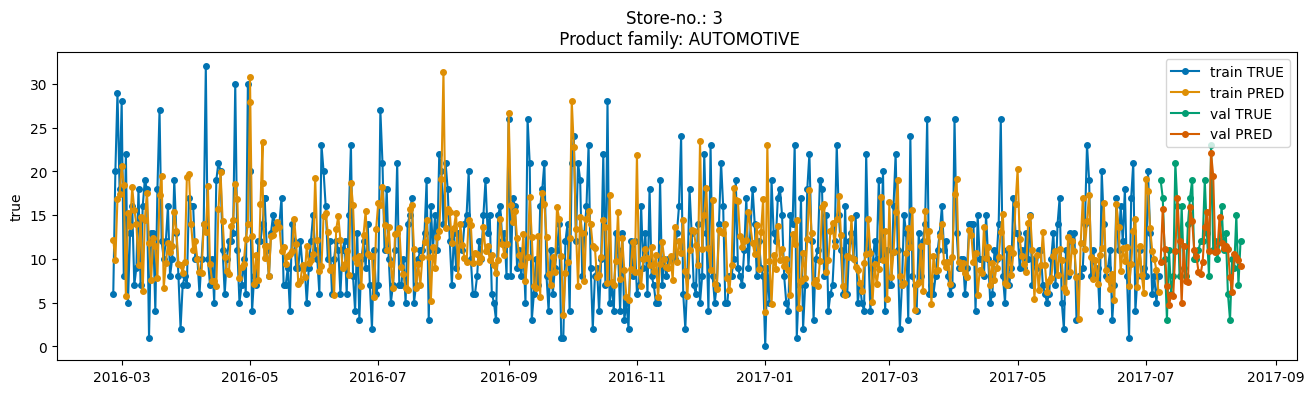

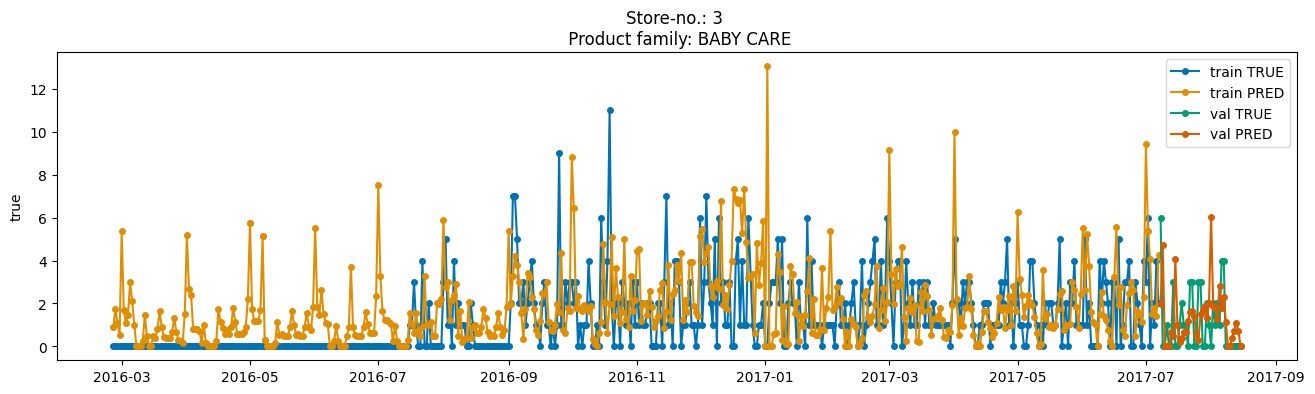

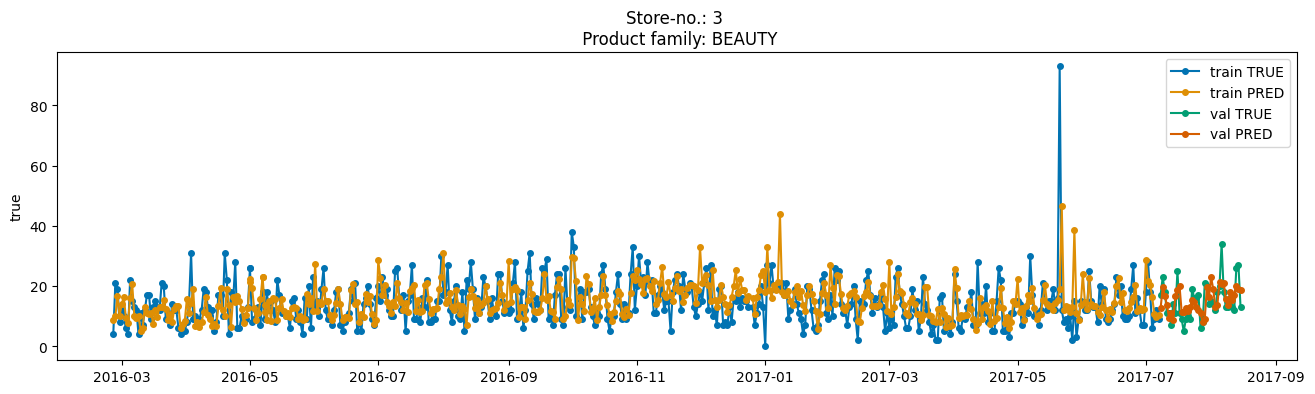

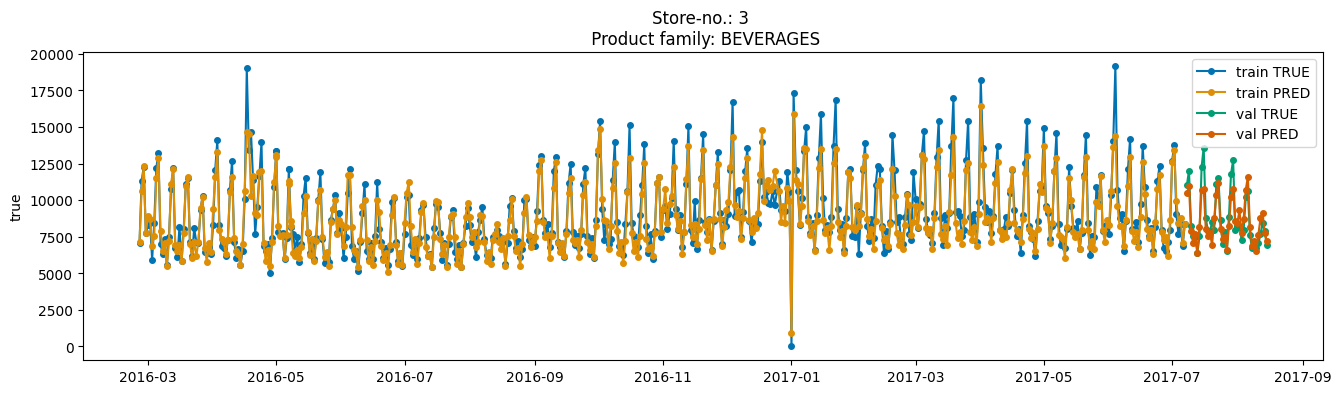

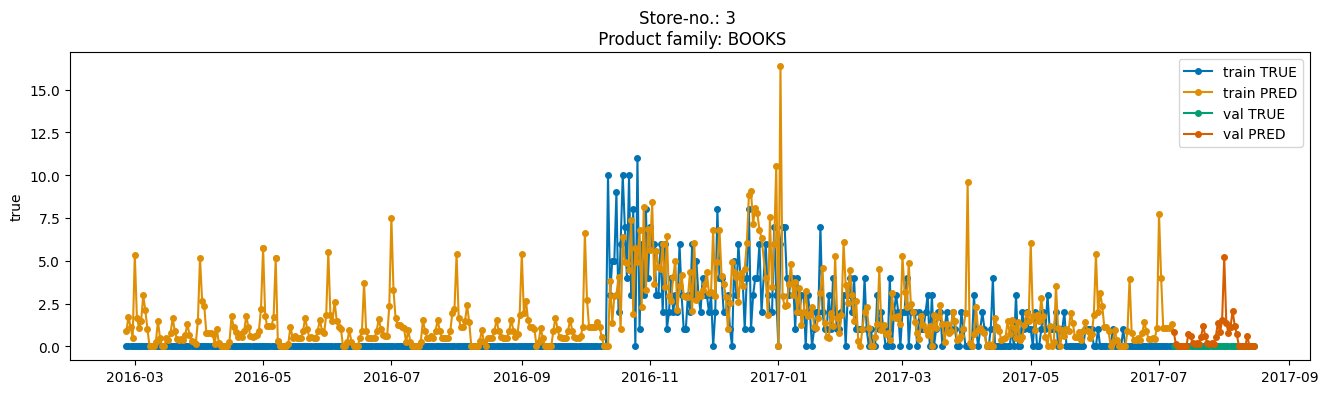

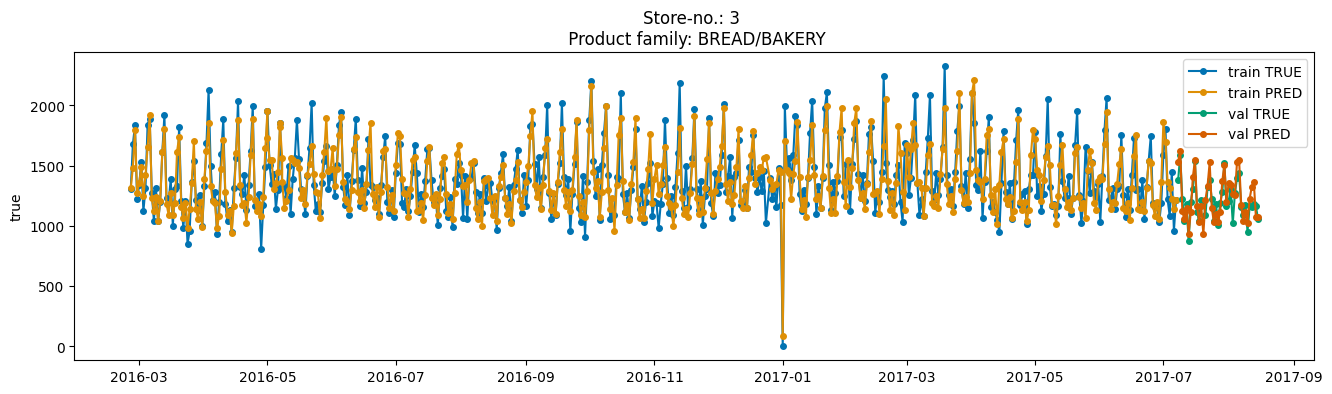

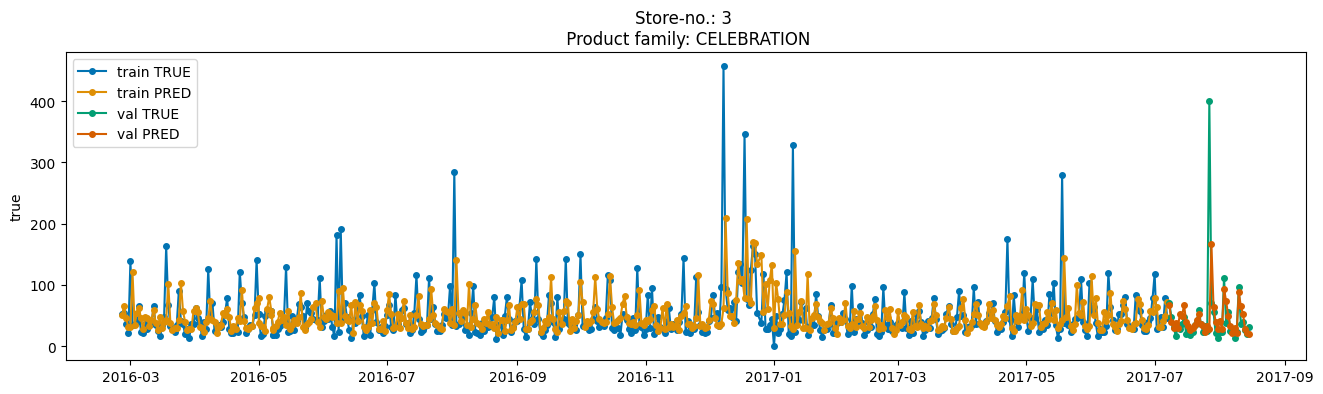

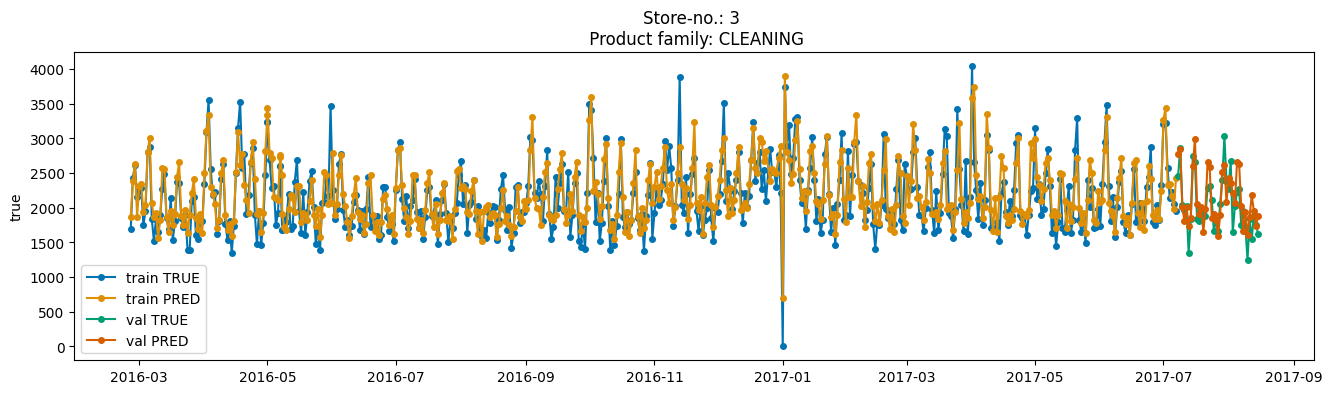

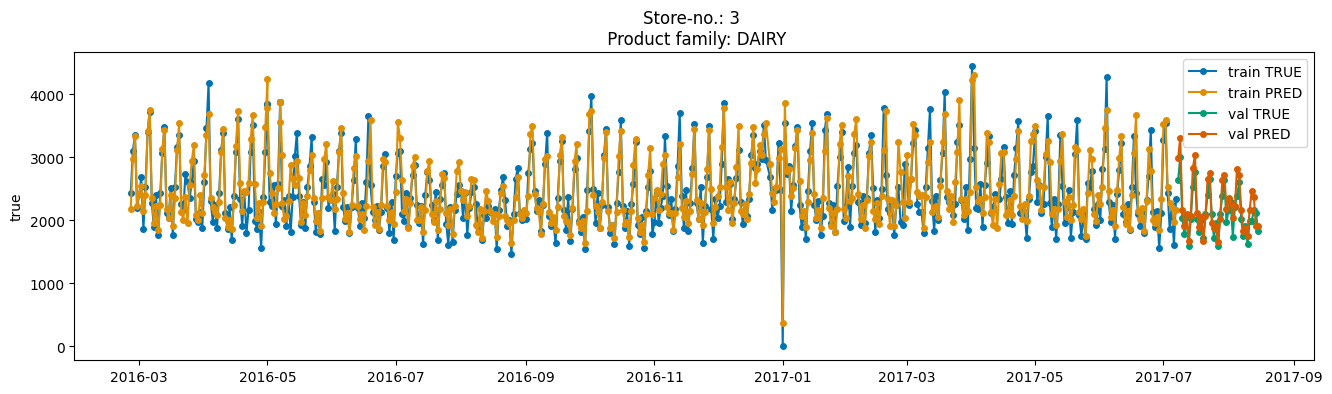

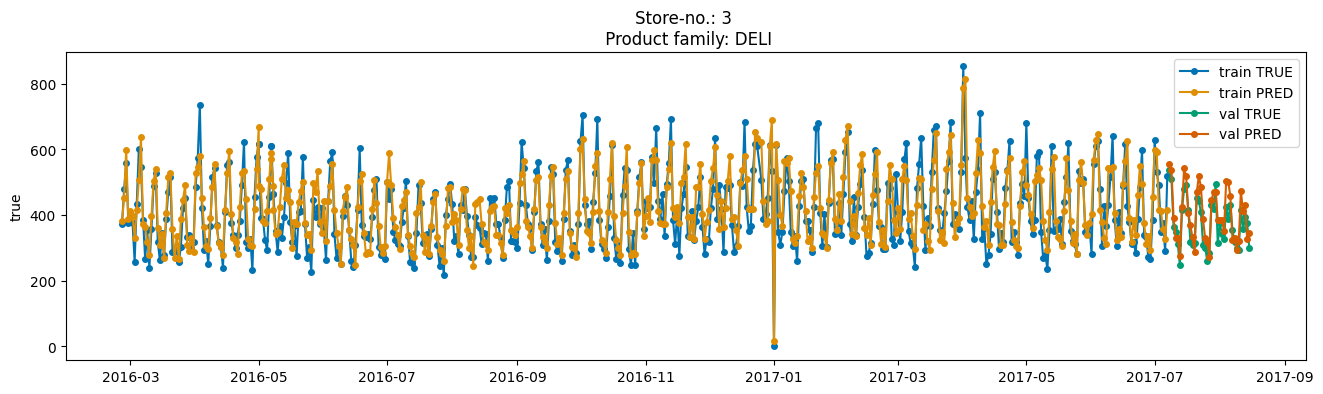

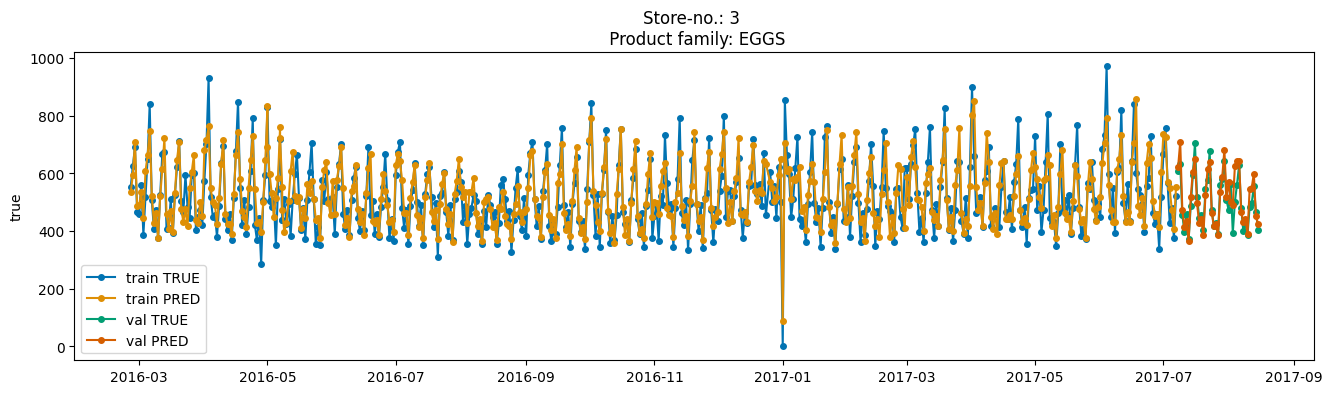

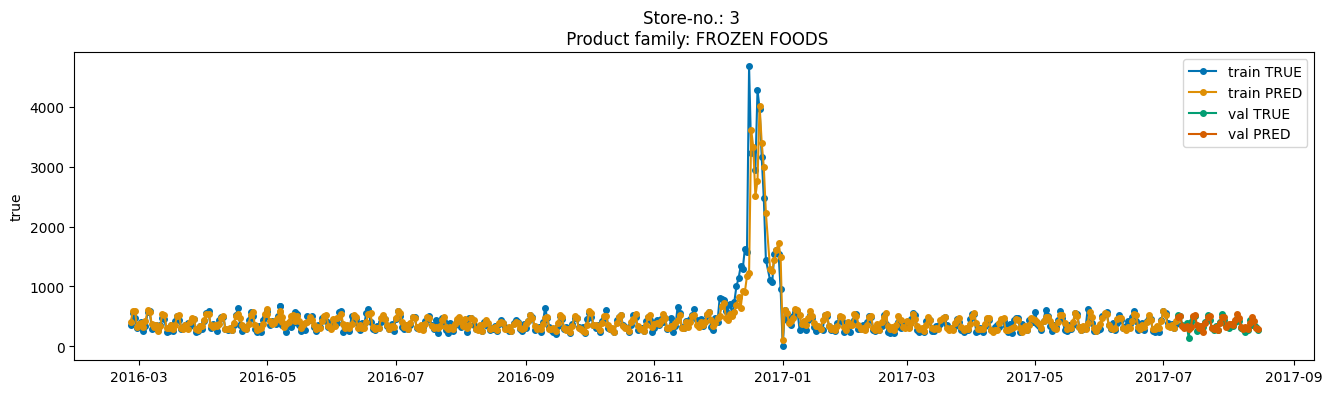

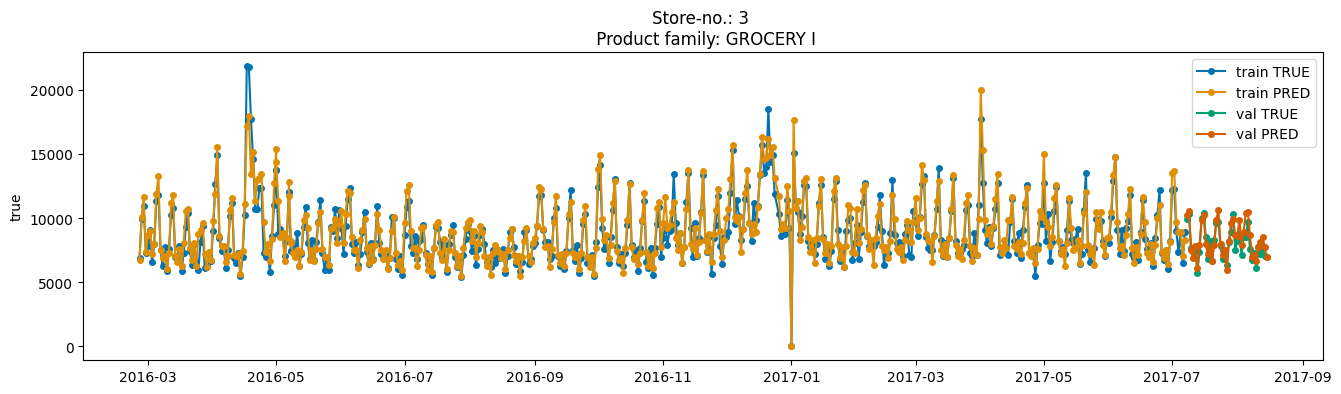

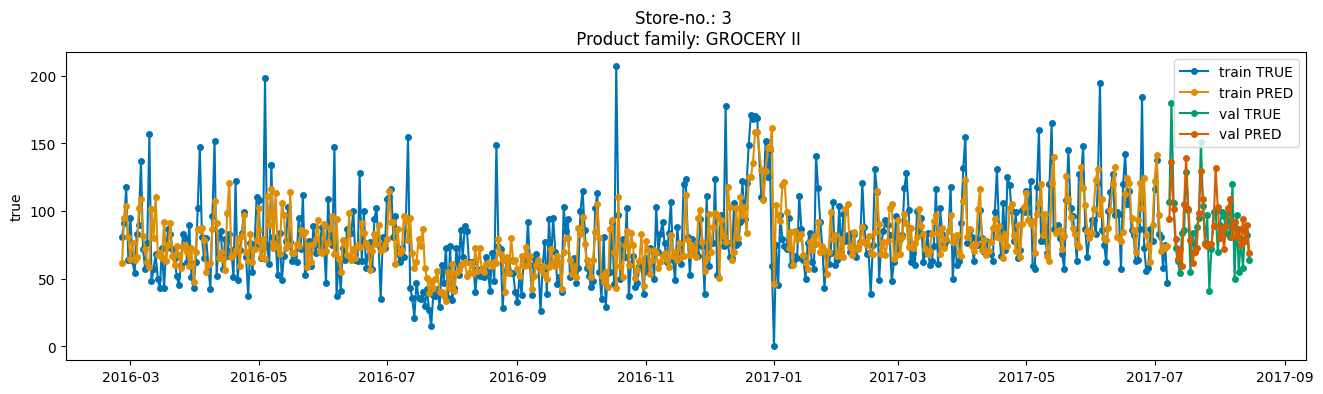

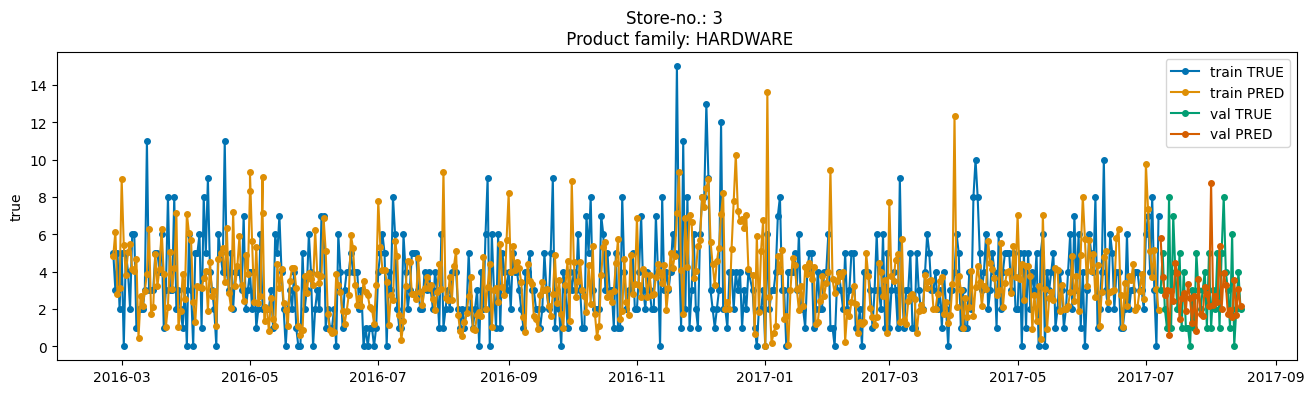

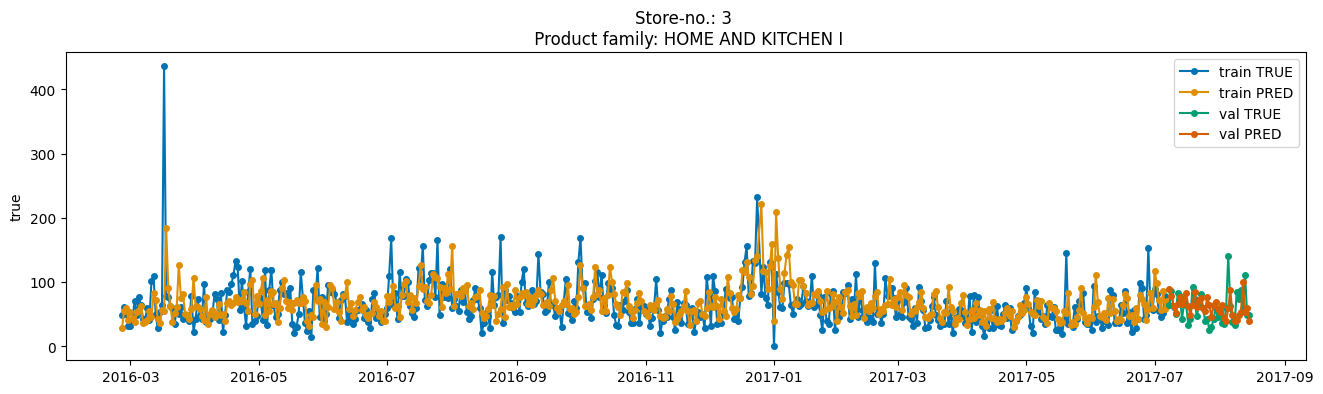

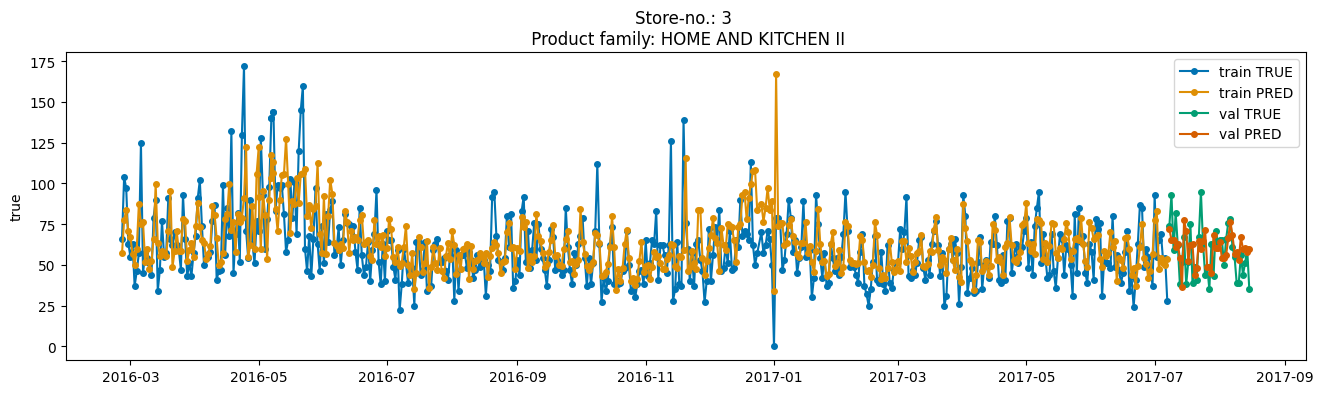

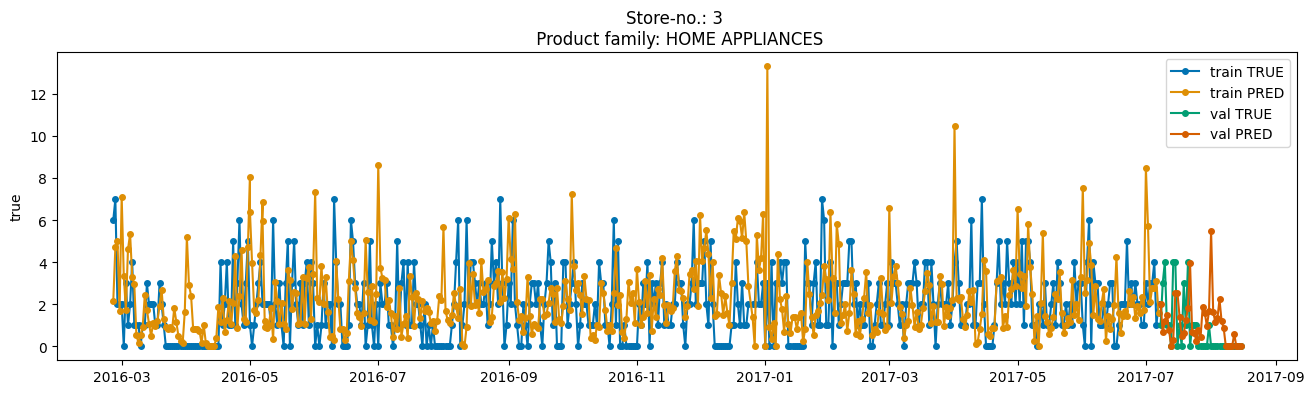

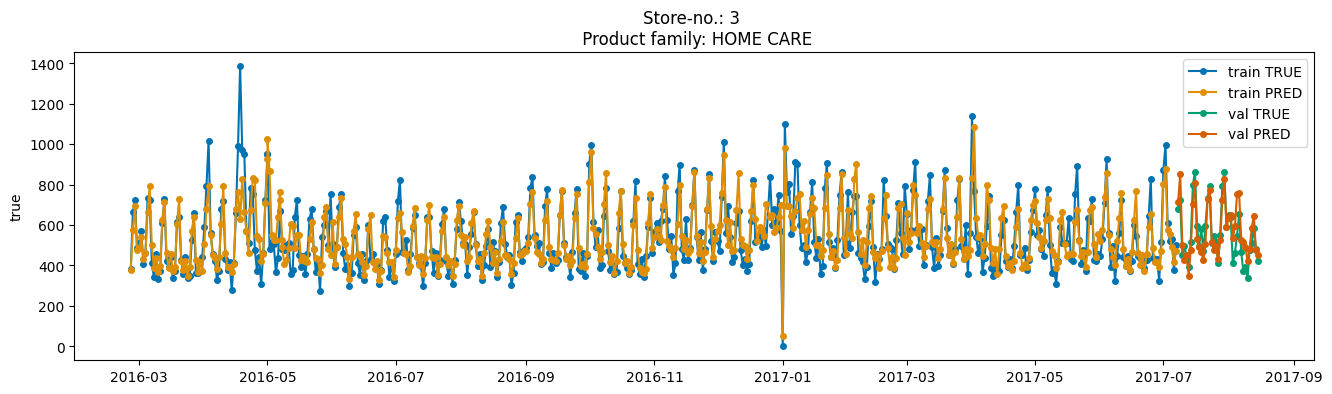

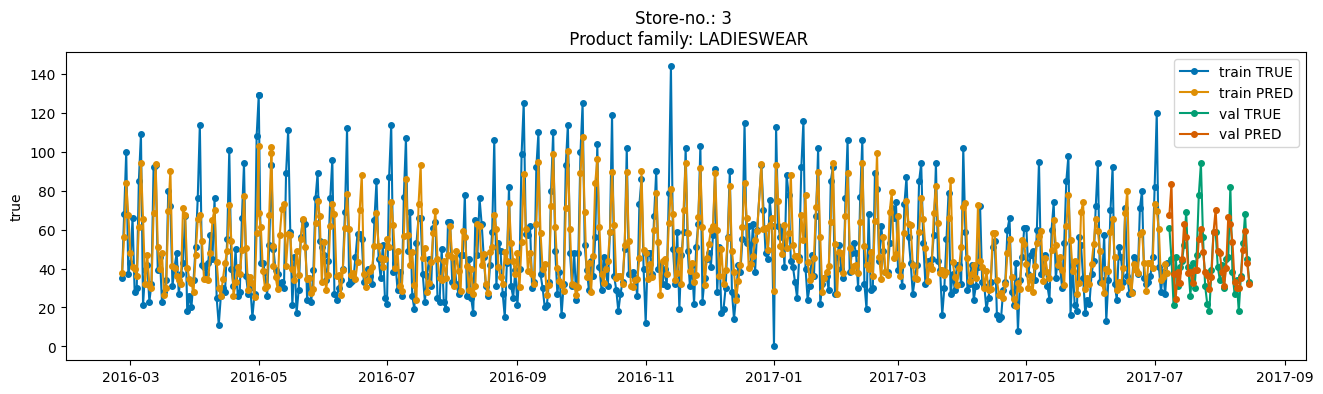

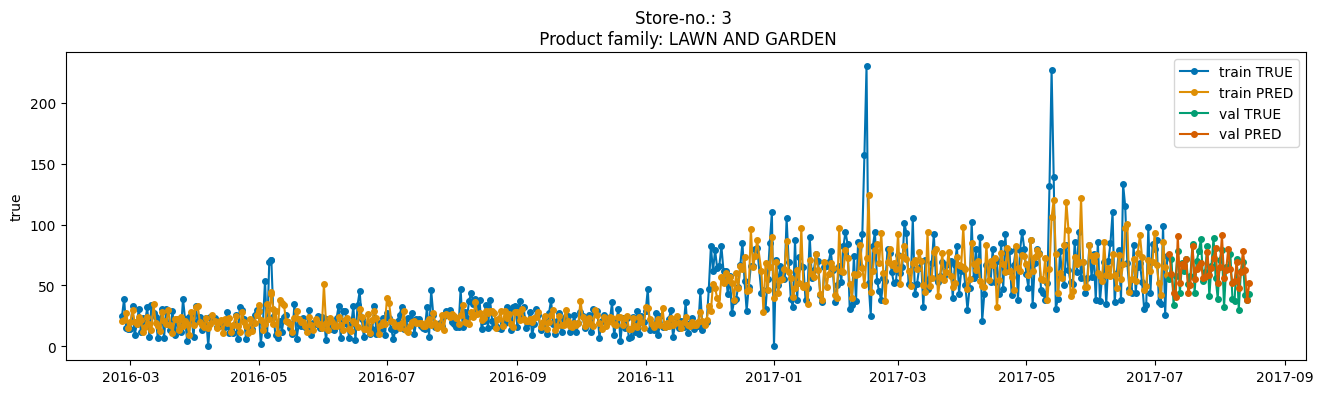

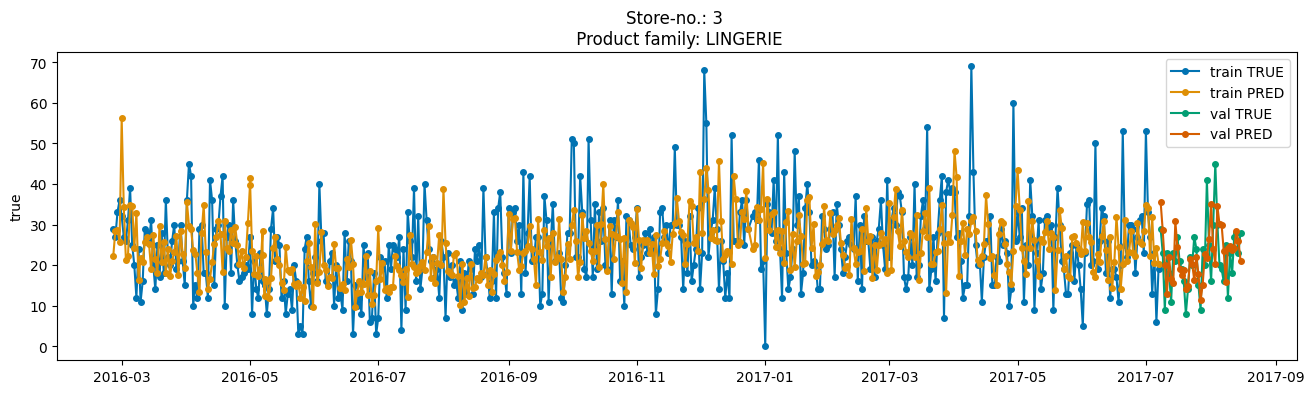

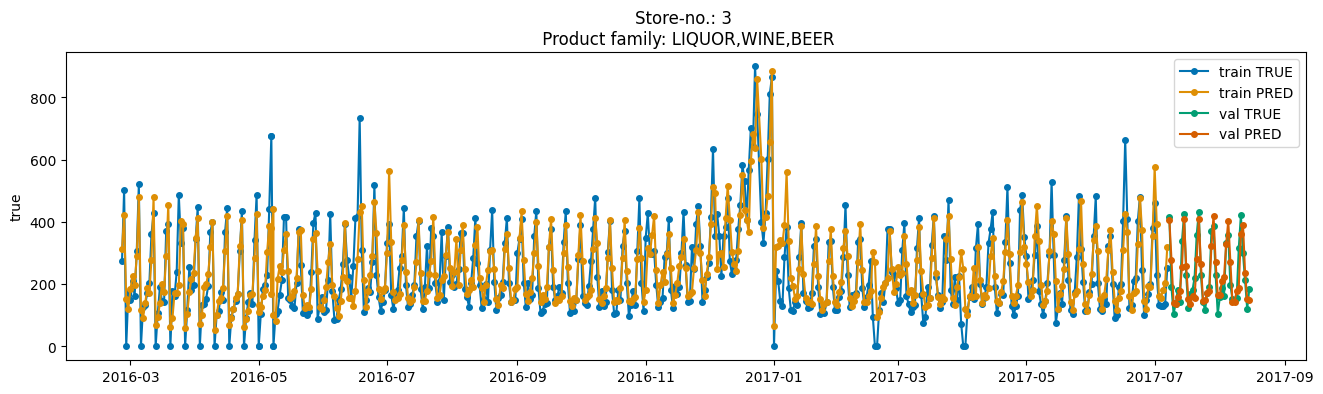

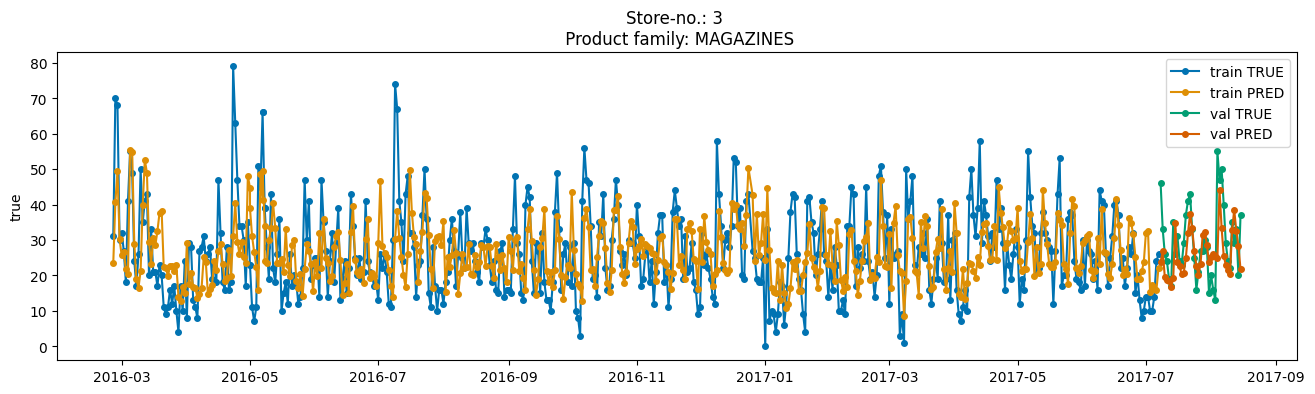

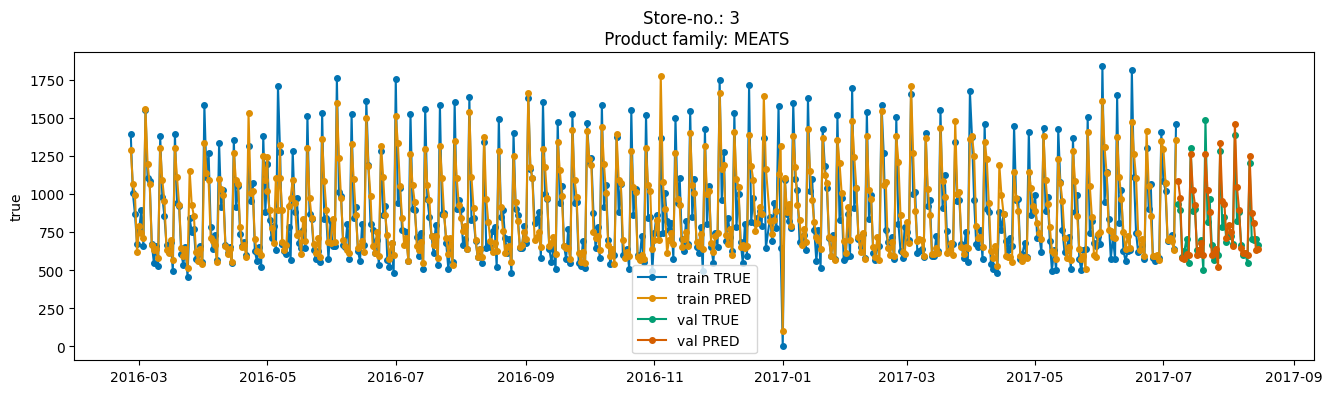

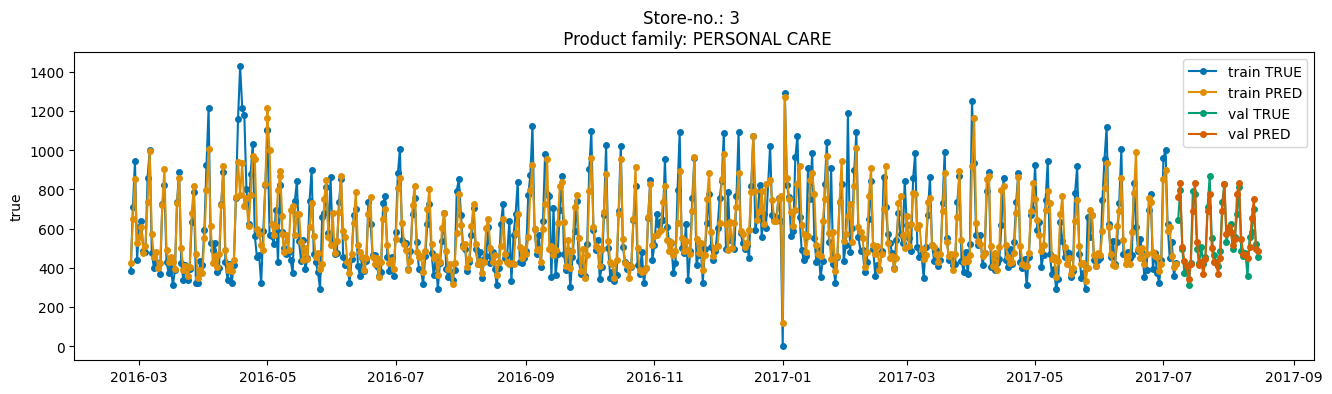

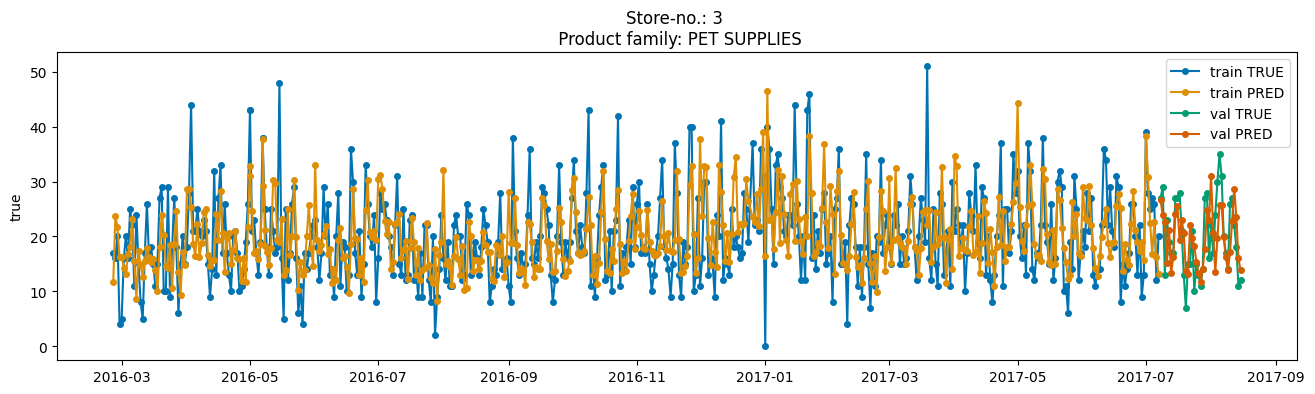

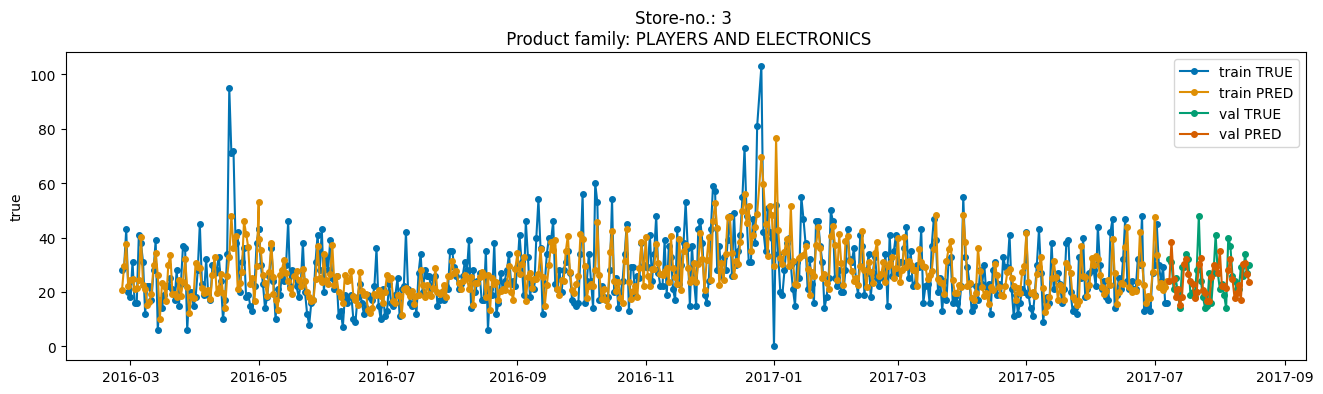

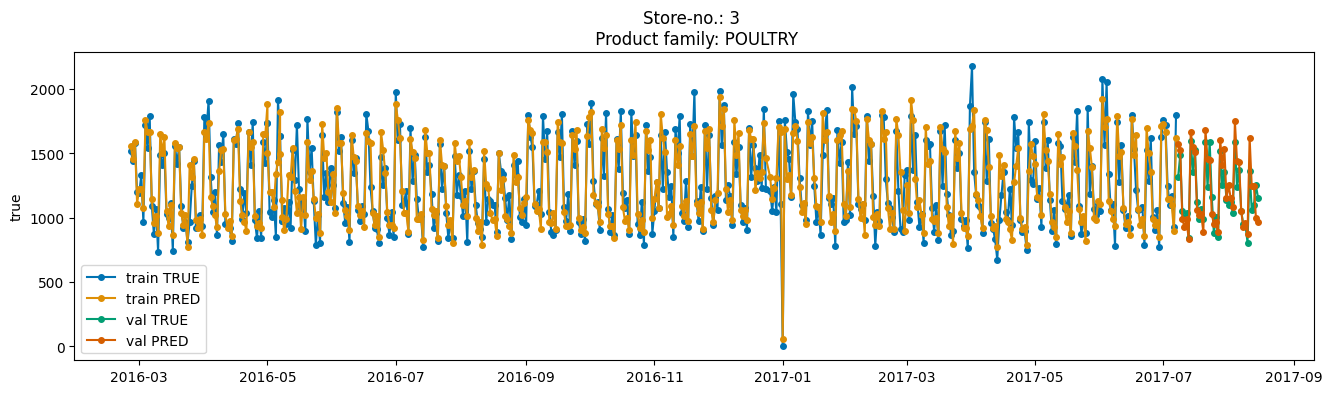

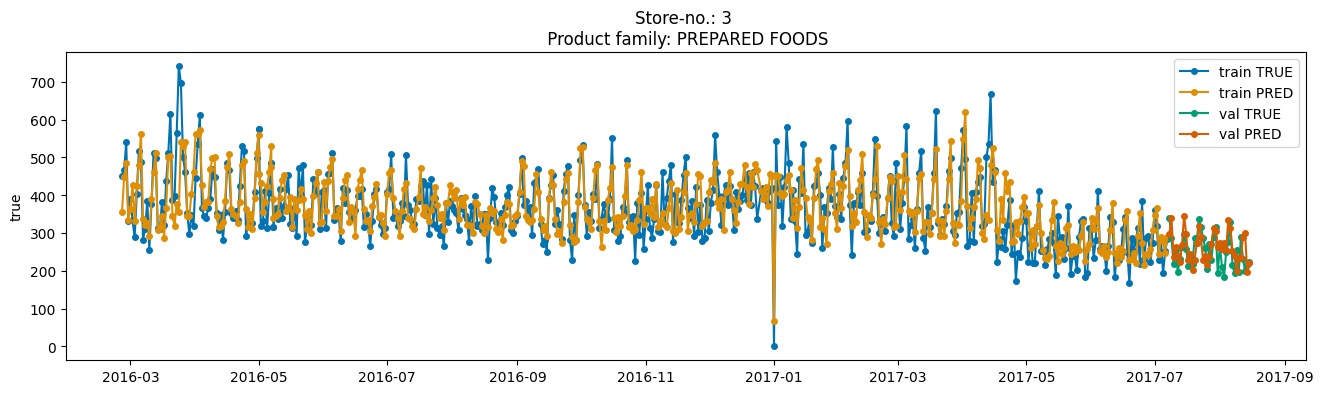

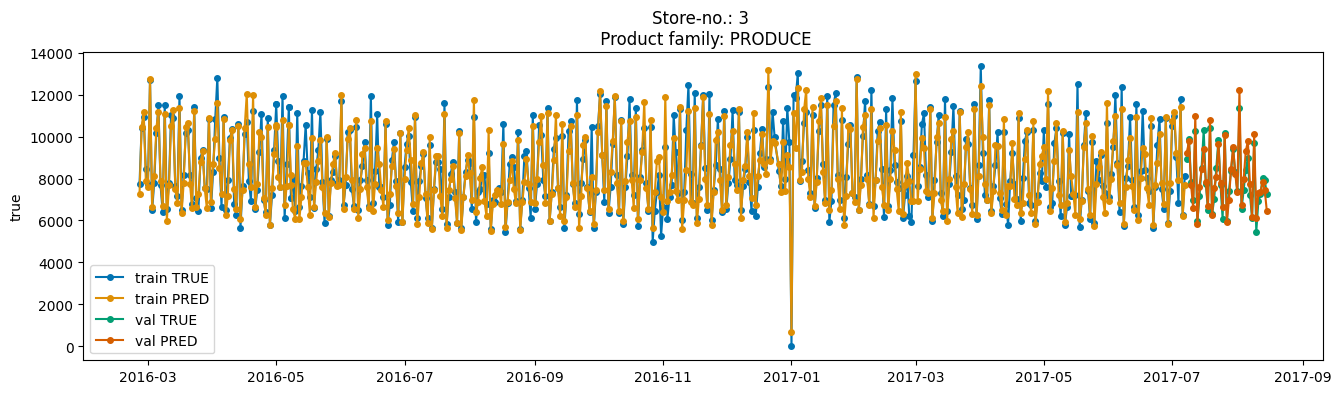

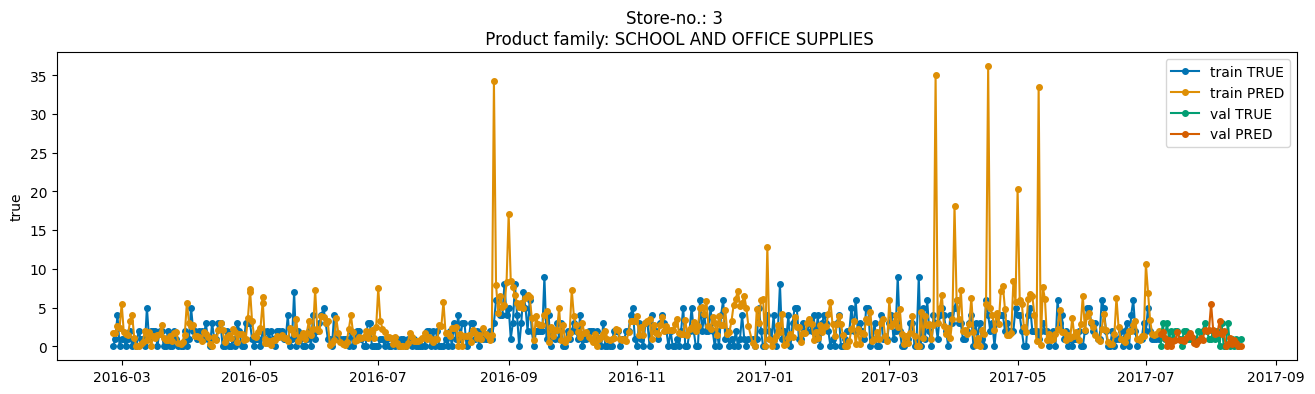

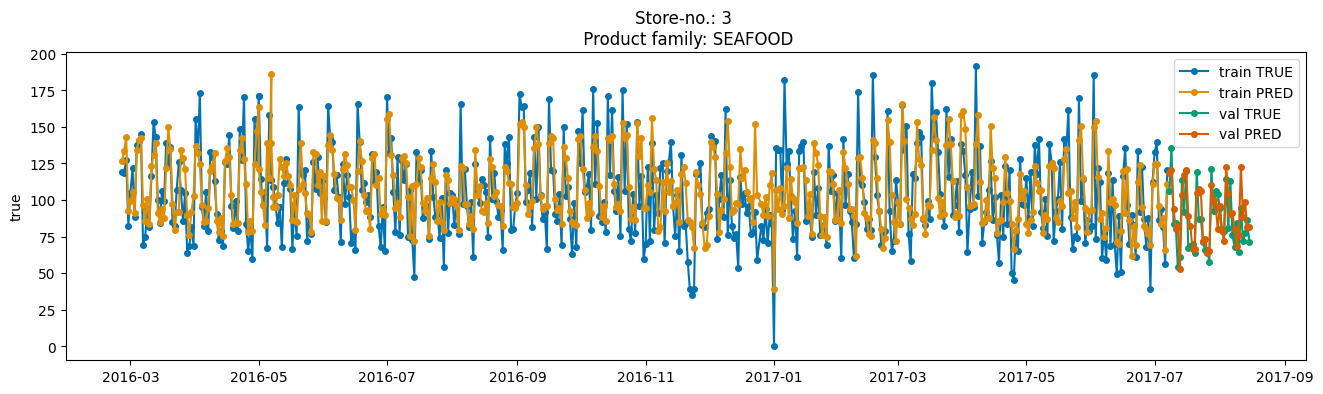

In [200]:
import matplotlib.pyplot as plt

for i in family:
    plot_results(dic_groups, 3, i, interval= 500)

## RandomSearch on new features

In [176]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2687256 entries, 320760 to 3008015
Columns: 112 entries, onpromotion to store_nbr_54
dtypes: UInt32(1), bool(87), float64(16), int32(3), int64(5)
memory usage: 717.6 MB


In [178]:
# Import necessary libraries
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_log_error
import warnings

# Suppress warnings from XGBoost
warnings.filterwarnings("ignore", category=UserWarning)

features = ['onpromotion', 'dcoilwtico', 'transactions', 'year', 'month', 'day', 
            'day_of_week_sin', 'day_of_week_cos', 'day_of_year_sin', 'day_of_year_cos',
            'week_of_year', 'time_since_last_promo', 'is_holiday', 
            'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 
            'sales_lag_60', 'sales_lag_90',
            'sales_roll_mean_7', 'sales_roll_mean_14', 
            'sales_roll_std_7', 'sales_roll_std_14',
            'promo_holiday', 'store_cluster_promo',
            'store_nbr', 'family']

# Step 1: Check for zero or negative sales values
def check_for_zero_negative_sales(df, target_column='sales'):
    num_invalid_sales = df[df[target_column] <= 0].shape[0]
    if num_invalid_sales > 0:
        print(f"Number of zero or negative sales: {num_invalid_sales}")
    else:
        print("No zero or negative sales found.")
    return num_invalid_sales

# Step 2: Handle zero or negative sales (either filter them or adjust by adding a constant)
def handle_zero_negative_sales(df, method='filter'):
    if method == 'filter':
        # Filter out zero or negative sales
        df_filtered = df[df['sales'] > 0]
        print(f"Filtered out rows with zero or negative sales. Remaining rows: {df_filtered.shape[0]}")
        return df_filtered
    elif method == 'add_constant':
        # Add a small constant to avoid zero or negative sales
        df['sales_adjusted'] = df['sales'] + 1
        print("Added constant of 1 to avoid zero or negative sales.")
        return df

# Step 3: Custom RMSLE scorer that clips negative predictions
def rmsle_scorer(y_true, y_pred):
    # Clip any negative predictions to 0 to avoid errors
    y_pred = np.clip(y_pred, a_min=0, a_max=None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Step 4: Perform Hyperparameter Tuning with RandomizedSearchCV
def perform_hyperparameter_tuning(X, y):
    # Ensure no zero or negative values in y before proceeding
    if (y <= 0).any():
        raise ValueError("Detected zero or negative values in target variable, can't proceed with RMSLE.")

    # Define the cleaned-up parameter grid for XGBoost
    param_grid = {
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 500, 1000],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'lambda': [0, 0.1, 1],  # L2 regularization
        'alpha': [0, 0.1, 1]  # L1 regularization
    }

    # Initialize XGBoost regressor
    xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1000)

    # Custom RMSLE scorer with clipping
    rmsle = make_scorer(rmsle_scorer, greater_is_better=False)

    # Set up RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgboost_model,
        param_distributions=param_grid,
        n_iter=50,
        scoring=rmsle,  # Use custom RMSLE scorer
        cv=3,  # 3-fold cross-validation
        verbose=1,  # Set verbosity to 1 for progress updates
        random_state=42,
        n_jobs=-1
    )

    # Perform the random search on the filtered training data
    random_search.fit(X, y)

    # Output the best parameters and the corresponding RMSLE score
    print("Best hyperparameters:", random_search.best_params_)
    print("Best score (RMSLE):", np.sqrt(-random_search.best_score_))

# Step 5: Clip negative model predictions
def clip_predictions(predictions):
    return np.clip(predictions, a_min=0, a_max=None)

# Step 6: Prepare and run everything
# Check for zero or negative sales in the training data
check_for_zero_negative_sales(df_train)

# Handle zero or negative sales based on the chosen method (either filter or add_constant)
df_train_cleaned = handle_zero_negative_sales(df_train, method='filter')

# Prepare feature matrix and target variable for training
X_filtered = encoding(df_train_cleaned[features], cat_columns)
y_filtered = df_train_cleaned['sales']


# Step 7: Ensure all target values are positive before proceeding
try:
    if (y_filtered <= 0).any():
        raise ValueError("Zero or negative values found in the target data!")

    # Print statistics on the target variable
    print(f"Min sales value: {y_filtered.min()}, Max sales value: {y_filtered.max()}")
    
    # Perform hyperparameter tuning
    perform_hyperparameter_tuning(X_filtered, y_filtered)
    
except ValueError as e:
    print(f"Error: {e}")


Number of zero or negative sales: 776837
Filtered out rows with zero or negative sales. Remaining rows: 1910419
Min sales value: 0.122, Max sales value: 124717.0
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'lambda': 0, 'colsample_bytree': 0.8, 'alpha': 0}
Best score (RMSLE): 0.8105090352288363


## GridSearch on new features

In [22]:
# # Import necessary libraries
# import numpy as np
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, mean_squared_log_error
# import warnings

# # Suppress warnings from XGBoost
# warnings.filterwarnings("ignore", category=UserWarning)

# # Updated feature list to include cyclic and interaction features
# features = ['onpromotion', 'dcoilwtico', 'transactions', 'year', 'month', 'day', 
#             'day_of_week_sin', 'day_of_week_cos', 'day_of_year_sin', 'day_of_year_cos',
#             'week_of_year', 'time_since_last_promo', 'is_holiday', 
#             'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 
#             'sales_lag_60', 'sales_lag_90',
#             'promo_holiday', 'store_cluster_promo']

# # Prepare the feature matrix and target variable
# X = df_train[features]
# y = df_train['sales']

# # Step 1: Check for zero or negative sales values
# def check_for_zero_negative_sales(df, target_column='sales'):
#     num_invalid_sales = df[df[target_column] <= 0].shape[0]
#     if num_invalid_sales > 0:
#         print(f"Number of zero or negative sales: {num_invalid_sales}")
#     else:
#         print("No zero or negative sales found.")
#     return num_invalid_sales

# # Step 2: Handle zero or negative sales (either filter them or adjust by adding a constant)
# def handle_zero_negative_sales(df, method='filter'):
#     if method == 'filter':
#         # Filter out zero or negative sales
#         df_filtered = df[df['sales'] > 0]
#         print(f"Filtered out rows with zero or negative sales. Remaining rows: {df_filtered.shape[0]}")
#         return df_filtered
#     elif method == 'add_constant':
#         # Add a small constant to avoid zero or negative sales
#         df['sales_adjusted'] = df['sales'] + 1
#         print("Added constant of 1 to avoid zero or negative sales.")
#         return df

# # Step 3: Custom RMSLE scorer that clips negative predictions
# def rmsle_scorer(y_true, y_pred):
#     # Clip any negative predictions to 0 to avoid errors
#     y_pred = np.clip(y_pred, a_min=0, a_max=None)
#     return np.sqrt(mean_squared_log_error(y_true, y_pred))

# # Step 4: Perform Hyperparameter Tuning with GridSearchCV
# def perform_hyperparameter_tuning(X, y):
#     # Ensure no zero or negative values in y before proceeding
#     if (y <= 0).any():
#         raise ValueError("Detected zero or negative values in target variable, can't proceed with RMSLE.")

#     # Define the cleaned-up parameter grid for XGBoost
#     param_grid = {
#         'max_depth': [3, 5, 7, 10],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'n_estimators': [100, 500, 1000],
#         'subsample': [0.7, 0.8, 0.9],
#         'colsample_bytree': [0.7, 0.8, 0.9],
#         'lambda': [0, 0.1, 1],  # L2 regularization
#         'alpha': [0, 0.1, 1]  # L1 regularization
#     }

#     # Initialize XGBoost regressor
#     xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1000)

#     # Custom RMSLE scorer with clipping
#     rmsle = make_scorer(rmsle_scorer, greater_is_better=False)

#     # Set up GridSearchCV
#     grid_search = GridSearchCV(
#         estimator=xgboost_model,
#         param_grid=param_grid,
#         scoring=rmsle,  # Use custom RMSLE scorer
#         cv=3,  # 3-fold cross-validation
#         verbose=1,  # Set verbosity to 1 for progress updates
#         n_jobs=-1
#     )

#     # Perform the grid search on the filtered training data
#     grid_search.fit(X, y)

#     # Output the best parameters and the corresponding RMSLE score
#     print("Best hyperparameters:", grid_search.best_params_)
#     print("Best score (RMSLE):", np.sqrt(-grid_search.best_score_))

# # Step 5: Clip negative model predictions
# def clip_predictions(predictions):
#     return np.clip(predictions, a_min=0, a_max=None)

# # Step 6: Prepare and run everything
# # Check for zero or negative sales in the training data
# check_for_zero_negative_sales(df_train)

# # Handle zero or negative sales based on the chosen method (either filter or add_constant)
# df_train_cleaned = handle_zero_negative_sales(df_train, method='filter')

# # Prepare feature matrix and target variable for training
# X_filtered = df_train_cleaned[features]  # Assuming features list is defined earlier
# y_filtered = df_train_cleaned['sales']

# # Step 7: Ensure all target values are positive before proceeding
# try:
#     if (y_filtered <= 0).any():
#         raise ValueError("Zero or negative values found in the target data!")

#     # Print statistics on the target variable
#     print(f"Min sales value: {y_filtered.min()}, Max sales value: {y_filtered.max()}")
    
#     # Perform hyperparameter tuning
#     perform_hyperparameter_tuning(X_filtered, y_filtered)
    
# except ValueError as e:
#     print(f"Error: {e}")


Number of zero or negative sales: 940483
Filtered out rows with zero or negative sales. Remaining rows: 2067533
Min sales value: 0.122, Max sales value: 124717.0
Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


KeyboardInterrupt: 